In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the data
data = pd.read_csv('Data/Final/Dataset.csv')
london_shp = gpd.read_file('Data/Revised/Geography/MSOA/London_2021.shp')

# Merge the data
data['Code_2021'] = data['Code_2021'].astype(str)
london_shp['msoa21cd'] = london_shp['msoa21cd'].astype(str)
gdf = london_shp.merge(data, left_on='msoa21cd', right_on='Code_2021', how='inner')

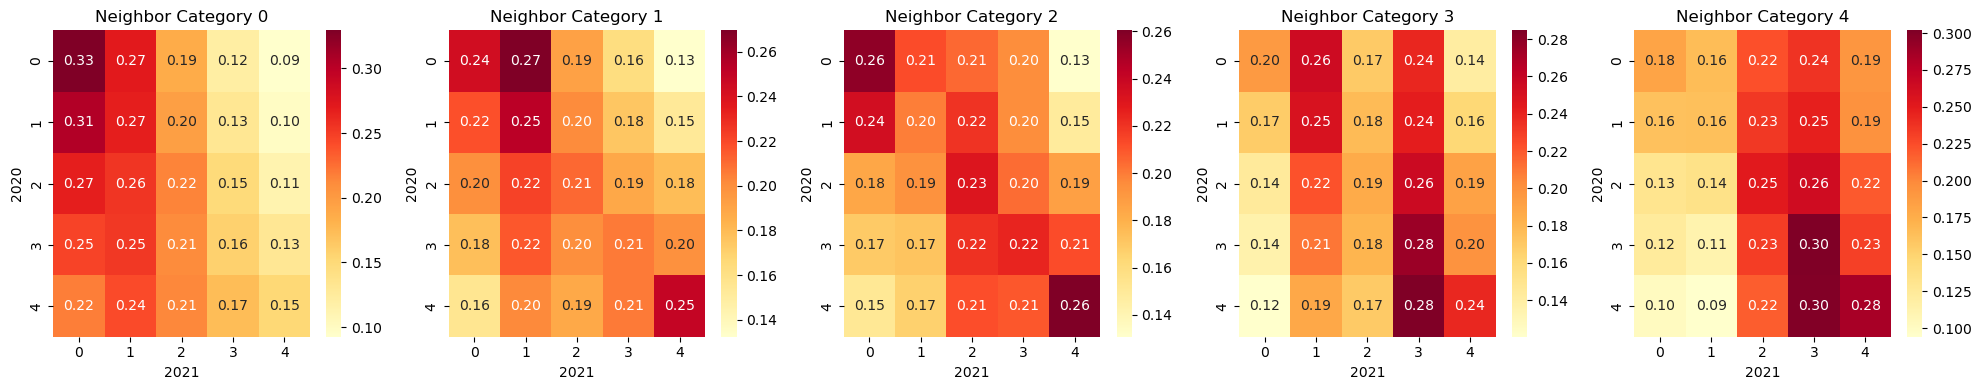

In [6]:
# Create a simplified spatial weights function
def create_spatial_weights(gdf, k=5):
    coords = np.column_stack((gdf.geometry.centroid.x, gdf.geometry.centroid.y))
    tree = cKDTree(coords)
    _, indices = tree.query(coords, k=k+1)
    return indices[:, 1:]  # Exclude itself

# Get spatial neighbors
neighbors = create_spatial_weights(gdf)

# Classify IMD data into 5 levels
gdf['IMD_2020_cat'] = pd.qcut(gdf['IMD_Before'], q=5, labels=range(5))
gdf['IMD_2021_cat'] = pd.qcut(gdf['IMD_After'], q=5, labels=range(5))

# Define a simplified Spatial Markov Transition Matrix function
def spatial_markov_matrix(data, neighbors, lag_attribute, attribute):
    n_classes = 5
    trans_matrix = np.zeros((n_classes, n_classes, n_classes))
    
    for i in range(len(data)):
        current_state = data[attribute].iloc[i]
        next_state = data[lag_attribute].iloc[i]
        neighbor_states = data[attribute].iloc[neighbors[i]].mode().iloc[0]
        
        trans_matrix[int(neighbor_states), int(current_state), int(next_state)] += 1
    
    # Normalize
    row_sums = trans_matrix.sum(axis=2)
    trans_matrix = np.divide(trans_matrix, row_sums[:, :, np.newaxis], where=row_sums[:, :, np.newaxis]!=0)
    
    return trans_matrix

# Calculate Spatial Markov Transition Matrix
trans_matrix = spatial_markov_matrix(gdf, neighbors, 'IMD_2021_cat', 'IMD_2020_cat')

# Visualize transition probabilities
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    sns.heatmap(trans_matrix[i], annot=True, cmap="YlOrRd", ax=axes[i], fmt='.2f')
    axes[i].set_title(f'Neighbor Category {i}')
    axes[i].set_xlabel('2021')
    axes[i].set_ylabel('2020')
plt.tight_layout()

# Export the image
output_path = "Data/spatial_markov_matrix.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [5]:
# Analyze transitions towards more impoverished directions (possible displacement)
downward_mobility = np.mean([trans_matrix[i, j, k] for i in range(5) for j in range(5) for k in range(j+1, 5)])
print(f"\nProbability of downward mobility (moving to a higher IMD category): {downward_mobility:.4f}")

# Identify the type of neighborhoods most prone to displacement
displacement_prone = np.argmax([trans_matrix[i, :, -1].sum() for i in range(5)])
print(f"\nNeighborhoods most prone to displacement: IMD Category {displacement_prone}")


Probability of downward mobility (moving to a higher IMD category): 0.1899

Neighborhoods most prone to displacement: IMD Category 4
